# TABLE OF CONTENTS:
---
* [Workspace](#Workspace)
* [Data](#Data)
* [Compute Target](#Compute-Target)
* [Training Artifacts](#Training-Artifacts)
* [Development Environment](#Development-Environment)
* [Compute Target](#Compute-Target)
* [Development Environment](#Development-Environment)
* [Experiment & Run Configuration](#Experiment-&-Run-Configuration)
* [Model Registration](#Model-Registration)
* [Resource Clean Up](#Resource-Clean-Up)
---

In [129]:
import azureml.core
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import sys
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Environment, Experiment, Model, ScriptRunConfig, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.widgets import RunDetails

from src.training.download_utils import download_and_extract_archive, unpickle_file

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.19.0


In [54]:
sys.path.append(os.path.dirname(os.path.abspath("")))

In [74]:
%load_ext autoreload
%autoreload 2

# Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the azureml SDK.

### Option 1: Create Workspace Object from Config

This option requires a config.json file containing the subscription id, resource group and workspace name. On an AML Compute Instance, this is available by default. For any other compute, the file can be downloaded from the workspace and put in the same directory as the calling file, a subdirectory named .azureml, or in a parent directory. Alternatively, the path can also be manually specified using the `path` argument.

<img src="../images/config_file.png" alt="config_file" width="600"/>

In [2]:
ws = Workspace.from_config() 
print("Workspace name: " + ws.name, 
      "Azure region: " + ws.location, 
      "Subscription id: " + ws.subscription_id, 
      "Resource group: " + ws.resource_group, sep="\n")

# Retrieve workspace details
# ws.get_details()

### Option 2: Create Workspace from Connection Info

In [3]:
# ws = Workspace.get(name="sbirk-aml-ws",
#                    subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
#                    resource_group="sbirk-aml-rg") 

# # Retrieve workspace details
# # ws.get_details()

# Data

For this template, the CIFAR-10 image dataset is used for multiclass classification. It has the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images in CIFAR-10 are three-channel color images of 32x32 pixels in size.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

[dataset](http://www.cs.toronto.edu/~kriz/cifar.html)

### Download Data

In [108]:
%%writefile $training_folder/download_utils.py
import os
import pickle
import scipy.io
import shutil
import urllib
import tarfile
import tqdm


def generate_bar_updater():
    """
    Create a tqdm reporthook function for urlretrieve
    :returns: bar_update function which can be used by urlretrieve 
              to display and update a progress bar
    """
    
    pbar = tqdm.tqdm(total=None)

    # Define progress bar update function
    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update


def _is_tarxz(file_name):
    return file_name.endswith(".tar.xz")


def _is_tar(file_name):
    return file_name.endswith(".tar")


def _is_targz(file_name):
    return file_name.endswith(".tar.gz")


def _is_tgz(file_name):
    return file_name.endswith(".tgz")


def _is_gzip(file_name):
    return file_name.endswith(".gz") and not file_name.endswith(".tar.gz")


def _is_zip(file_name):
    return file_name.endswith(".zip")


def extract_archive(from_path, to_path=None, remove_finished=False):
    """
    Extract a given archive
    :param from_path: path to archive which should be extracted
    :param to_path: path to which archive should be extracted
        default: parent directory of from_path
    :param remove_finished: if set to True, delete archive after extraction
    """

    # If archive does not exist, do nothing
    if not os.path.exists(from_path):
        print(f"There is no archive {from_path}")
        return

    # If no to_path is indicated, use parent directory of from_path as to_path
    if to_path is None:
        to_path = os.path.dirname(from_path)
        
    print(f"Extracting archive {from_path} to {to_path}")

    # Check for file extension and extract the archive
    if _is_tar(from_path):
        with tarfile.open(from_path, 'r') as tar:
            tar.extractall(path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, 'r:gz') as tar:
            tar.extractall(path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, 'r:xz') as tar:
            tar.extractall(path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(
            to_path,
            os.path.splitext(os.path.basename(from_path))[0]
        )
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, 'r') as zip_:
            zip_.extractall(to_path)
    else:
        raise ValueError(f"Extraction of {from_path} not supported")

    # Remove archive if flag is True
    if remove_finished:
        print(f"Removing archive file {from_path}")
        os.remove(from_path)


def download_file(download_url, file_dir, file_name, skip_if_dir_exists=False, force_dir_deletion=False):
    """
    Download a file
    :param download_url: url from where to download
    :param file_dir: directory to which to download
    :param file_name: name of the file
    :param skip_if_dir_exists: if set to True, skip the download if the directory already exists
    :param force_dir_deletion: if set to True, delete the existing directory before the download
    """
    
    # Remove file directory if it exists
    if force_dir_deletion:
        shutil.rmtree(file_dir)
    
    # Check if download should be triggered
    if not os.path.exists(file_dir) or not skip_if_dir_exists:
    
        # Create file directory if it does not exist
        os.makedirs(file_dir, exist_ok=True)
    
        # Download the file
        file_path = os.path.join(file_dir, file_name)
        print("Downloading " + download_url + " to " + file_path)
        urllib.request.urlretrieve(download_url, filename=file_path, reporthook=generate_bar_updater())


def download_and_extract_archive(download_url, file_dir, archive_file_name, skip_if_dir_exists=False, force_dir_deletion=False):
    """
    Download and extract a given archive
    :param download_url: url from where to download
    :param file_dir: root directory to which to download
    :param archive_file_name: name of the archive
    :param skip_if_dir_exists: if set to True, skip the download if the directory already exists
    :param force_dir_deletion: if set to True, delete the existing directory before the download
    """
    
    # Download the archive
    download_file(download_url=download_url, file_dir=file_dir, file_name=archive_file_name,
                  skip_if_dir_exists=skip_if_dir_exists, force_dir_deletion=force_dir_deletion)
    
    # Extract the archive
    extract_archive(from_path=file_path, remove_finished=True)
    
    
def download_and_extract_stanford_dog_dataset():
    
    mat_files_path = "../data/mat_files"
    
    download_and_extract_archive(download_url="http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar",
                                 file_dir=mat_files_path,
                                 archive_file_name="lists.tar",
                                 force_download=True)
    
    train_list_mat = scipy.io.loadmat(os.path.join(mat_files_path, "train_list.mat")
    test_list_mat = scipy.io.loadmat(os.path.join(mat_files_path, "test_list.mat")

    training_files = []
    test_and_val_files = []

    # Extract training data file names
    for array in train_list_mat["file_list"]:
        training_files.append(training_file_array[0][0])
    
    # Extract test data file names
    for array in test_list_mat["file_list"]:
        test_and_val_files.append(array[0][0])
    
    training_dir = "../data/train"
    val_dir = "../data/val"
    test_dir = "../data/test"

    tar = tarfile.open("../data/images.tar")

    test_val_idx = 0
    for member in tar.getmembers():
        if member.isreg(): # Skip if the TarInfo is not files
            member.name = member.name.split("/", 1)[1] # Retrieve only relevant part of file name
            
            # Extract files to corresponding directories
            if member.name in training_files:
                tar.extract(member, training_dir)
                
            elif member.name in test_and_val_files: # Every 2nd file goes to the validation data
                test_val_idx+=1
                if test_val_idx % 2 != 0:
                    tar.extract(member, val_dir)
                else:
                    tar.extract(member, test_dir)
        
                                     
def unpickle_file(file_path, encoding="bytes"):
    with open(file_path, "rb") as file:
        unpickled_object = pickle.load(file, encoding=encoding)
    return unpickled_object

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci/code/Users/s.birk/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/download_utils.py


Debug script locally.

In [109]:
archive_file_list = ["images.tar", "lists.tar"]

for archive_file in archive_file_list:
    download_and_extract_archive(download_url="http://vision.stanford.edu/aditya86/ImageNetDogs/" + archive_file,
                                 file_dir="../data",
                                 archive_file_name=archive_file,
                                 skip_if_dir_exists=False,
                                 force_dir_deletion=False)

0it [00:00, ?it/s]

100%|█████████▉| 790970368/793579520 [02:34<00:00, 19473618.85it/s]

Extracting archive ../data/images.tar to ../data


793583616it [24:34, 538047.05it/s]                                 
0it [00:00, ?it/s]

Removing archive file ../data/images.tar


 92%|█████████▏| 442368/481280 [00:02<00:00, 320779.84it/s]

Extracting archive ../data/lists.tar to ../data
Removing archive file ../data/lists.tar


In [106]:


download_and_extract_archive(download_url="http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
                             file_dir="../data",
                             archive_file_name="images.tar",
                             =True)

In [98]:
download_and_extract_archive(download_url="http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar",
                             file_dir="../data",
                             archive_file_name="lists.tar",
                             force_download=True)

0it [00:00, ?it/s]

 92%|█████████▏| 442368/481280 [00:02<00:00, 318240.95it/s]

Extracting archive ../data/lists.tar to ../data
Removing archive file ../data/lists.tar


In [ ]:
archive_file_list = ["images.tar", "lists.tar"]
file_dirs = ["", "Lists"]

In [175]:
import os, tarfile

training_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"

tar = tarfile.open("../data/images.tar")

test_val_idx = 0
for member in tar.getmembers():
    if member.isreg(): # Skip if the TarInfo is not files
        member.name = member.name.split("/", 1)[1] # Retrieve only relevant part of file name
        
        # Extract files to corresponding directories
        if member.name in training_files:
            tar.extract(member, training_dir)
            
        elif member.name in test_and_val_files: # Every 2nd file goes to the validation data
            test_val_idx+=1
            if test_val_idx % 2 != 0:
                tar.extract(member, val_dir)
            else:
                tar.extract(member, test_dir)

KeyboardInterrupt: 

In [169]:
train_list_mat = scipy.io.loadmat("../data/train_list.mat")
test_list_mat = scipy.io.loadmat("../data/test_list.mat")

training_files = []
test_and_val_files = []

# Extract training data file names
for array in train_list_mat["file_list"]:
    training_files.append(training_file_array[0][0])
    
# Extract test data file names
for array in test_list_mat["file_list"]:
    test_and_val_files.append(array[0][0])

In [120]:

mat = scipy.io.loadmat("../data/file_list.mat")

In [124]:
len(mat["file_list"])

20580

In [130]:

train_mat = scipy.io.loadmat("../data/train_list.mat")
test_mat = scipy.io.loadmat("../data/test_list.mat")

In [133]:
test_mat["file_list"]


array([[array(['n02085620-Chihuahua/n02085620_2650.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_4919.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_1765.jpg'], dtype='<U38')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_3635.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_2988.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_6330.jpg'], dtype='<U48')]],
      dtype=object)

In [128]:
len(train_mat["file_list"])

12000

In [103]:
mat["file_list"].shape

(20580, 1)

In [81]:
dict123 = unpickle_file("../data/cifar-10-batches-py/data_batch_1")

In [84]:
dict123.keys().decode("utf-8")

AttributeError: 'dict_keys' object has no attribute 'decode'

In [86]:
dict1234 = {key.decode('utf-8'): value for (key, value) in dict123.items()}

In [111]:
from torchvision import datasets

image_datasets = {x: datasets.ImageFolder("../data/Images")
                  for x in ['train', 'val']}

In [116]:
len(image_datasets["train"])

20580

In [119]:
download_data()

extracting files...
finished extracting


'fowl_data/'

Use the Pytorch dataset and dataloader classes to download the CIFAR-10 data to the AML Compute Instance / local compute.

In [4]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create train dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root="../data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


### Explore Data

Display the first batch of 4 CIFAR-10 images.

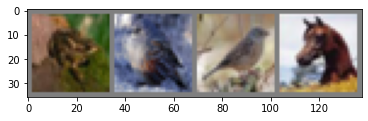

       frog        bird        bird       horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(" ".join("%11s" % classes[labels[j]] for j in range(4)))

### Upload Data

Upload the data to the default AML datastore.

In [6]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir="../data", target_path="data/cifar-10", overwrite=True)

Uploading an estimated of 9 files
Uploading ../data/cifar-10-batches-py/batches.meta
Uploaded ../data/cifar-10-batches-py/batches.meta, 1 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/readme.html
Uploaded ../data/cifar-10-batches-py/readme.html, 2 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/test_batch
Uploaded ../data/cifar-10-batches-py/test_batch, 3 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_1
Uploaded ../data/cifar-10-batches-py/data_batch_1, 4 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_2
Uploaded ../data/cifar-10-batches-py/data_batch_2, 5 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_3
Uploaded ../data/cifar-10-batches-py/data_batch_3, 6 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_4
Uploaded ../data/cifar-10-batches-py/data_batch_4, 7 files out of an estima

$AZUREML_DATAREFERENCE_4f917631c0624272a88eb404e2d7f9f4

### Create and Register AML Dataset

In [7]:
# Create a dataset object from datastore location
dataset = Dataset.File.from_files(path=(datastore, "data/cifar-10"))

# Register the dataset
dataset = dataset.register(workspace=ws,
                           name="cifar-10-dataset",
                           description="cifar-10 training dataset",
                           create_new_version=True)

# Compute Target

Create a remote compute target to run the experiment on. The below code will first check whether a compute target with name `cpu_cluster_name` already exists and if it does it will use that.

In [8]:
# Choose a name for the CPU cluster
cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # CPU
                                                           # vm_size='STANDARD_NC6', # GPU
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=2400)
    
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# Use get_status() to get a detailed status for the current cluster
print(compute_target.get_status().serialize())

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Training Artifacts

Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with Azure ML without having to modify your code.

However, if you would like to use Azure ML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of Azure ML code inside your training script. 

In [9]:
# Create a folder for the training artifacts
training_folder = os.path.join(os.getcwd(), "../src/training")
os.makedirs(training_folder, exist_ok=True)

A training script is created in the aml_training folder. This folder will contain all artifacts needed for aml remote training and these will be copied to the remote compute at runtime.

In [ ]:
%%writefile $training_folder/train.py
import argparse
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import urllib

from azureml.core import Run
from model import Net
from utils import download_and_extract_data
from zipfile import ZipFile

run = Run.get_context()


def load_data(data_dir):
    """Load the training and validation data."""

    # Apply data augmentation and normalization for training data
    # Apply just normalization for validation data
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(24), # Crop 24x24 image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

def train_model(model, criterion, optimizer, scheduler, num_epochs, data_dir):
    """Train the model."""

    # load training/validation data
    dataloaders, dataset_sizes, class_names = load_data(data_dir)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # log the best val accuracy to AML run
            run.log('best_val_acc', np.float(best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def fine_tune_model(num_epochs, data_dir, learning_rate, momentum):
    """Load a pretrained model and reset the final fully connected layer."""

    # log the hyperparameter metrics to the AML run
    run.log('lr', np.float(learning_rate))
    run.log('momentum', np.float(momentum))

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)  # only 2 classes to predict

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(),
                             lr=learning_rate, momentum=momentum)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer_ft, step_size=7, gamma=0.1)

    model = train_model(model_ft, criterion, optimizer_ft,
                        exp_lr_scheduler, num_epochs, data_dir)

    return model


def main():
    print("Torch version:", torch.__version__)

    # get command-line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_epochs', type=int, default=25,
                        help='number of epochs to train')
    parser.add_argument('--output_dir', type=str, help='output directory')
    parser.add_argument('--learning_rate', type=float,
                        default=0.001, help='learning rate')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
    args = parser.parse_args()

    data_dir = download_data()
    print("data directory is: " + data_dir)
    model = fine_tune_model(args.num_epochs, data_dir,
                            args.learning_rate, args.momentum)
    os.makedirs(args.output_dir, exist_ok=True)
    torch.save(model, os.path.join(args.output_dir, 'model.pt'))


if __name__ == "__main__":
    main()

    
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path to the training data")
    parser.add_argument("--learning_rate", type=float, default=0.01, help="Learning rate for SGD")
    parser.add_argument("--momentum", type=float, default=0.9,help="Momentum for SGD")

    args = parser.parse_args()

    print("")
    print("========== DATA ==========")
    print("Data Location: " + args.data_path)
    print("Available Files:", os.listdir(args.data_path))
    print("==========================")
    print("")

    # Create dataloader for CIFAR-10 training data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, 
                                            download=False, transform=transform)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Define convolutional network
    net = Net()
    net.to(device)

    # Set up pytorch cross entropy loss and SGD optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=args.momentum)

    print("===== MODEL TRAINING =====")
    
    # Train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Unpack the data
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Run forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log("loss", loss) # log loss metric to AML
                print(f"epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}")
                running_loss = 0.0

    print("Finished training")
    print("==========================")
    print("")
    
    os.makedirs("outputs", exist_ok=True)
    file_path = "outputs/cifar_net.pt"
    torch.save(net.state_dict(), file_path) # Anything written to the outputs folder on remote compute is automatically uploaded to the run outputs 
    # run.upload_file(name=file_path, path_or_stream=file_path)
    
    print("Saved and uploaded model")

In [10]:
%%writefile $training_folder/train.py
import os
import argparse
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Run
from model import Net


run = Run.get_context()

if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path to the training data")
    parser.add_argument("--learning_rate", type=float, default=0.01, help="Learning rate for SGD")
    parser.add_argument("--momentum", type=float, default=0.9,help="Momentum for SGD")

    args = parser.parse_args()

    print("")
    print("========== DATA ==========")
    print("Data Location: " + args.data_path)
    print("Available Files:", os.listdir(args.data_path))
    print("==========================")
    print("")

    # Create dataloader for CIFAR-10 training data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, 
                                            download=False, transform=transform)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Define convolutional network
    net = Net()
    net.to(device)

    # Set up pytorch cross entropy loss and SGD optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=args.momentum)

    print("===== MODEL TRAINING =====")
    
    # Train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Unpack the data
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Run forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log("loss", loss) # log loss metric to AML
                print(f"epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}")
                running_loss = 0.0

    print("Finished training")
    print("==========================")
    print("")
    
    os.makedirs("outputs", exist_ok=True)
    file_path = "outputs/cifar_net.pt"
    torch.save(net.state_dict(), file_path) # Anything written to the outputs folder on remote compute is automatically uploaded to the run outputs 
    # run.upload_file(name=file_path, path_or_stream=file_path)
    
    print("Saved and uploaded model")

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci/code/Users/s.birk/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/train.py


Create a model file which contains the network architecture.

In [11]:
%%writefile $training_folder/model.py
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci/code/Users/s.birk/pytorch-use-cases-azure-ml/template_project/notebooks/../src/training/model.py


Run the training script locally for debugging.

In [12]:
!python ../src/training/train.py --data_path ../data --learning_rate 0.003 --momentum 0.9

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:St

# Development Environment

In [ ]:
%%writefile ../environments/conda/environment.yml

name: pytorch-aml-env
dependencies:
- python=3.7.1
- pytorch::pytorch=1.7.0
- pytorch::torchvision=0.8.1
- pip:
    - azureml-defaults
    - azureml-sdk
    - azureml-widgets
channels:
- pytorch

A yml file with conda environment specification is provided in `../environments/conda`. By instantiating an environment object, this conda environment can be used for the remote training run. Alternatively, AML curated environments can also be used. AML curated environments cover common ML scenarios and are backed by cached Docker images. Cached Docker images make the first remote run preparation faster.

In [14]:
# # Display AML Curated Environments
# envs = Environment.list(workspace=ws)

# for env in envs:
#     if env.startswith("AzureML"):
#         print("Name", env)
#         print("packages", envs[env].python.conda_dependencies.serialize_to_string())

In [22]:
# # List workspace environments
# for name, env in ws.environments.items():
#     print(f"Name {name} \t version {env.version}")

# # Retrieve an environment
# env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.3-CPU", version="1")

# # Get base image of retrieved environment
# print(env.docker.base_image)

# print("\n Attributes of retrieved environment:")
# env

On the first run in a given environment, Azure ML spends some time building the environment. On the subsequent runs, Azure ML keeps track of changes and uses the existing environment, resulting in faster run completion.

In [13]:
env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="../environments/conda/environment.yml")

# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.
# env.docker.enabled = True

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

## Only uncomment one of the three below options
# OPTION 1: Use mcr base image
#env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"
#env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04' # GPU base image

# Option 2: Use custom base image from workspace-native ACR
#env.docker.base_image = "eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io/base/pytorch"

# OPTION 3: Use custom base image from standalone ACR. For this you need to enable admin user in the ACR.
env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
env.docker.base_image_registry.username = "sbirkacr"
env.docker.base_image_registry.password = "HqAu5Y2We0gZ42IunR5MBXkKc+shf2uj" # replace with Key Vault

# Create an environment variable.
# This can be retrieved in the training script with os.environ.get("MESSAGE").
# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "sbirkacr.azurecr.io/base/pytorch",
        "baseImageRegistry": {
            "address": "sbirkacr.azurecr.io",
            "password": "AzureMlSecret=Env_6fcaf5e93072233a74a9029bc46b9053f295a40aad026a7b040a96b945c549f5_2#EnvironmentDefinition#ContainerRegistry#Password",
            "registryIdentity": null,
            "username": "sbirkacr"
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "pytorch-aml-env",
    "python": {
        "baseCondaEnvironme

# Experiment & Run Configuration

Now that the training artifacts are prepared, a model can be trained on the remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Option 1: "Normal" Script Run

In [14]:
# Create the experiment
experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

# Create the script run configuration
config = ScriptRunConfig(source_directory="../src/training",
                         script="train.py",
                         compute_target=cpu_cluster_name,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--learning_rate", 0.003,
                             "--momentum", 0.92])

config.run_config.environment = env

# Submit the run
run = experiment.submit(config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Option 2: Hyperdrive Run

In [15]:
# Get portal URL
run.get_portal_url()

'https://ml.azure.com/experiments/cifar-image-classification-pytorch/runs/cifar-image-classification-pytorch_1610261279_b1a313b8?wsid=/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourcegroups/sbirk-aml-rg/workspaces/sbirk-aml-ws'

In [16]:
run.wait_for_completion(show_output=False)

{'runId': 'cifar-image-classification-pytorch_1610261279_b1a313b8',
 'target': 'cpu-cluster',
 'status': 'Finalizing',
 'startTimeUtc': '2021-01-10T07:05:25.872776Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '224a4f54-bf80-4e81-b961-0e5b68ac397c',
  'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '8bb56f81322f46a37ae25e9fdd92bced22a373e6',
  'mlflow.source.git.commit': '8bb56f81322f46a37ae25e9fdd92bced22a373e6',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'b392cc2b-166d-4d90-a004-63716d19f8ab'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input', 'mechan

In [15]:
# Check run metrics, details and file names
print(run.get_metrics())
print(run.get_details())
print(run.get_file_names())

{'loss': [2.0413564110696316, 1.7357404006272554, 1.6161067148000001, 1.5915769870132208, 1.5596799415498972, 1.5253833034932613, 1.474745139680803, 1.5081596463024616, 1.4987276076860725, 1.5030428788289427, 1.5029170999862254, 1.4870155130643397]}
['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/65_job_prep-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'cifar_net.pt', 'logs/azureml/79_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_565d07a1-9849-4fff-b50f-f815a0065d23.jsonl', 'logs/azureml/dataprep/engine_spans_e5a231dc-b108-

# Model Registration

In [16]:
model_path = "outputs/cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=model_path,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

print(model.name, model.id, model.version, sep="\t")

In [ ]:
# Download the model
run.download_file(name=os.path.join("../", model_path))

# Resource Clean Up

In [ ]:
# cpu_cluster.delete()

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/get-started-day1/day1-part4-data.png)

In [18]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="your-tenant-id")
Additional details on authentication can be found here: https://aka.ms/aml-notebook-auth 

SyntaxError: invalid syntax (<ipython-input-18-aa630af4f9d4>, line 3)

> <span style="color:purple; font-weight:bold">! NOTE <br>
> The very first run will take 5-10minutes to complete. This is because in the background a docker image is built in the cloud, the compute cluster is resized from 0 to 1 node, and the docker image is downloaded to the compute. Subsequent runs are much quicker (~15 seconds) as the docker image is cached on the compute - you can test this by resubmitting the code below after the first run has completed.</span>

> <span style="color:purple; font-weight:bold">! NOTE <br>
> The first time you run this script, Azure Machine Learning will build a new docker image from your PyTorch environment. The whole run could take 5-10 minutes to complete. You can see the docker build logs in the widget by selecting the `20_image_build_log.txt` in the log files dropdown. This image will be reused in future runs making them run much quicker.</span>

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies in the Azure ML environment don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the Azure ML environment. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.

To run this notebook you will need to create an Azure Machine Learning _compute instance_. The benefits of a compute instance over a local machine (e.g. laptop) or cloud VM are as follows:

* It is a pre-configured with all the latest data science libaries (e.g. panads, scikit, TensorFlow, PyTorch) and tools (Jupyter, RStudio). In this tutorial we make extensive use of PyTorch, AzureML SDK, matplotlib and we do not need to install these components on a compute instance.
* Notebooks are seperate from the compute instance - this means that you can develop your notebook on a small VM size, and then seamlessly scale up (and/or use a GPU-enabled) the machine when needed to train a model.
* You can easily turn on/off the instance to control costs. 